# Chebyshev collocation method

We want to solve the rational expectations model:
\begin{equation}
\mathbb{E}_t\left[R(x_t, \varepsilon_{t+1}; g, \theta)\right] = 0
\end{equation}
where $g$ is the policy function. To do so, we would like to approximate $g$ over the domain $[\underline{x},\bar{x}]$.

We choose the approximating function:
$$ \Phi(x_t, \theta) \equiv \sum_{i = 0}^{n} \theta_i T_i (\phi(x_t)) $$ 
where $T_i$ is the Chebyshev polynomial of order $i = 0,\dots, n$. The problem then reduces to finding $\theta$ such that 
\begin{equation}
\mathbb{E}_t\left[R(x_i, \varepsilon_{t+1}; \Phi, \theta)\right] = 0 \,\, \text{for} \,\, i = 0, \dots, n
\end{equation}

Consider the following version of the Neo-classical growth model:
$$
y_t = \exp(a_t) k^{\alpha}
$$
$$
c_t^\sigma - \beta \mathbb{E}_t \left[c_{t+1}^\sigma(\alpha \exp(a_{t+1}) k_{t+1}^{\alpha -1} + 1 - \delta)\right] = 0
$$
$$
k_{t+1} = \exp(a_t) k_t^\alpha - c_t + (1 - \delta) k_t
$$
$$
a_{t+1} = \rho a_t + \varepsilon_{t+1}, \quad \varepsilon_t \sim \mathcal{N}(0, \sigma_\varepsilon^2)
$$

Using the defintion of the AR(1) process, the Euler equation can be written as:
$$
c^{-\sigma}_t - \frac{1}{\sqrt{2 \pi} \sigma_\varepsilon} \int_{-\infty}^{+\infty} \left[ c_{t+1}^{-\sigma} (\alpha \exp(\rho a_{t} + \varepsilon_{t+1}) k_{t+1}^{\alpha -1} + 1 - \delta)\right] \exp{\left(\frac{-\varepsilon_{t+1}^2}{\sigma_\varepsilon^2}\right)} d \varepsilon_{t+1} = 0
$$


Since we assume Gaussian errors for the AR(1), we use [Gauss-Hermite quadrature](https://en.wikipedia.org/wiki/Gauss%E2%80%93Hermite_quadrature) to approximate the expectation integral in the Euler equation:
$$
c_t^{-\sigma} - \frac{1}{\sqrt{\pi}} \sum_{j = 1}^{q} \omega_j \left[ c_{t+1}^{-\sigma} (\alpha \exp{(\rho a_{t} + z_j \sqrt{2} \sigma_\varepsilon)} k_{t+1}^{\alpha -1} + 1 - \delta)\right] = 0
$$
where $ z_j = \frac{\varepsilon_j}{\sqrt{2} \sigma_\varepsilon}$ is a change of variable to accomodate the Gauss-Hermite formulation.

We approximate the consumption policy function such that:
$$
c_t \approx \Phi(k_t, a_t, \theta) \equiv \exp{\left(\sum_{j_k = 0}^{n_k} \sum_{j_a = 0}^{n_a} \theta_{j_k j_a} T_{j_k}(\varphi(\log(k_t)) T_{j_a}(\varphi(a_t)) \right)}
$$
is a linear combination of Chebyshev polynomials in the state variables $k$ and $a$.

In [10]:
# Computational imports
import numpy as np
from scipy import optimize as opt
from numba import njit

# Graphics imports
import matplotlib.pyplot as plt
from matplotlib import cm # for 3d poltting
from mpl_toolkits.mplot3d.axes3d import Axes3D # for 3d poltting

In [11]:
@njit
def scale_up(z,x_min,x_max):
    """
    Scales up z \in [-1,1] to x \in [x_min,x_max]
    where z = (2 * (x - x_min) / (x_max - x_min)) - 1
    """
    
    return x_min + (z + 1) * (x_max - x_min) / 2

@njit
def scale_down(x,x_min,x_max):
    """
    Scales down x \in [x_min,x_max] to z \in [-1,1]
    where z = f(x) = (2 * (x - x_min) / (x_max - x_min)) - 1
    """    
    
    return (2 * (x - x_min) / (x_max - x_min)) - 1

In [12]:
# Parameters

δ = 0.1
β = 0.95
α = 0.3 
σ = 1.5
ρ = 0.8
σ_ε = 0.2
μ = 0

In [4]:
# non-stochastic steady state

ky_ratio = 1 / ((1-β*(1-δ))/(α*β))
y_ss = ky_ratio**(α/(1 - α))
k_ss = y_ss**(1/α)
i_ss = δ * k_ss
c_ss = y_ss - i_ss

### Chebyshev collocation with same number of nodes and coefficients (just-determined system)

In [6]:
n_k = 4 # degree of polynomials in k (number of coefficients is n_k + 1)
n_a = 2 # degree of polynomials in a (number of coefficients is n_a + 1)

nn_k = n_k + 1 # number of nodes for k
nn_a = n_a + 1 # number of nodes for a

n_quad = 12 # number of nodes and weights for quadrature (should be equal to total number of coefficients)

In [7]:
# Use the hermgauss function to get the nodes and weights for the Gauss-Hermite quadrature
gh_nodes, gh_weights = np.polynomial.hermite.hermgauss(n_quad)

gh_nodes = gh_nodes * np.sqrt(2) * σ_ε # convert z to ε

In [8]:
# generate chebyshev nodes (the roots of the chebyshev polynomials)
r_a = -np.cos((2*np.arange(1,nn_a+1) - 1) * np.pi / (2*nn_a))

# transform nodes into a space taking into account GH nodes
a_min = gh_nodes[0] + μ
a_max = gh_nodes[-1] + μ
a_grid = scale_up(r_a,a_min,a_max)

# builds the Vandermonde matrix of Chebyshev polynomial expansion at the r_a nodes
# using the recurrence relation
T_a = np.zeros((nn_a,n_a+1))

T_a[:,0] = np.ones((nn_a,1)).T

T_a[:,1] = r_a.T

for i in range(1,n_a):
    T_a[:,i+1] = 2 * r_a * T_a[:,i] - T_a[:,i-1]

# or numpy's routine
#T_a = np.polynomial.chebyshev.chebvander(r_a,n_a) 

In [268]:
# generate chebyshev nodes (the roots of the chebyshev polynomials)
r_k = -np.cos((2*np.arange(1,nn_k+1) - 1) * np.pi / (2*nn_k))

# transform nodes into k space
k_min = np.log(0.1)
k_max = np.log(6)
k_grid = np.exp(scale_up(r_k,k_min,k_max))

# builds the Vandermonde matrix of Chebyshev polynomial expansion at the r_a nodes
# using the recurrence relation
T_k = np.zeros((nn_k,n_k+1))

T_k[:,0] = np.ones((nn_k,1)).T

T_k[:,1] = r_k.T

for i in range(1,n_k):
    T_k[:,i+1] = 2 * r_k * T_k[:,i] - T_k[:,i-1]

# or numpy's routine
#T_k = np.polynomial.chebyshev.chebvander(r_k,n_k) 

In [272]:
# initial guess for policy function

c_init = np.zeros((nn_a,nn_k))

for i_a in range(nn_a):
    
    for i_k in range(nn_k):
        
        c_init[i_a,i_k] = np.exp(a_grid[i_a]) * k_grid[i_k]**α + (1 - δ) * k_grid[i_k]

# initial guess for Chebyshev coefficients
θ_init = (T_a.T @ np.log(c_init) @ T_k) / np.outer(np.diag(T_a.T @ T_a), np.diag(T_k.T @ T_k).T ) # use Matrix outer product for the denominator
θ_init

array([[ 6.62068910e-01,  1.24921110e+00,  1.04559014e-01,
         2.12515794e-03, -1.35953880e-03],
       [ 6.10007022e-01, -3.28934328e-01, -1.17140988e-02,
         1.00661850e-02,  7.11249937e-04],
       [ 5.86578997e-02,  8.74643002e-03, -1.21604492e-02,
        -1.23640303e-03,  8.24569171e-04]])

Now that we computed the polynomials, we need to find the Chebyshev coefficients that minimize the residual function:

$$
c_t^{-\sigma} - \frac{1}{\sqrt{\pi}} \sum_{j = 1}^{q} \omega_j \left[ \beta c_{t+1}^{-\sigma} (\alpha \exp{(\rho a_{t} + z_j \sqrt{2} \sigma_\varepsilon)} k_{t+1}^{\alpha -1} + 1 - \delta)\right] = 0
$$
where $ z_j = \frac{\varepsilon_j}{\sqrt{2} \sigma_\varepsilon}$

In [364]:
#@jit(nopython=False)
def residuals(θ):
    """
    returns the residuals of the Euler equation using a Chebyshev approximation of the consumption policy function with coefficients θ.
    """
    
    θ = θ.reshape((nn_a,nn_k))
    
    ssr = np.zeros((nn_a,nn_k))

    for j_a in range(nn_a):

        for j_k in range(nn_k):

            c = np.exp(T_a[j_a,:] @ θ @ T_k[j_k,:].T)

            k_p = np.exp(a_grid[j_a]) * k_grid[j_k]**α - c + (1 - δ) * k_grid[j_k]
            
            k_p = np.fmin(np.fmax(k_p,np.exp(k_min)), np.exp(k_max))
            
            r_kp = scale_down(np.log(k_p),k_min,k_max)
            
            if np.any(np.abs(r_kp) > 1):
                print('Root of k outside unit circle at state point: ',j_a,j_k)

            T_kp = np.zeros((1,n_k+1))

            T_kp[:,0] = np.ones((1,1)).T

            T_kp[:,1] = r_kp #r_kp.T

            for i in range(1,n_k):
                T_kp[:,i+1] = 2 * r_kp * T_kp[:,i] - T_kp[:,i-1]

            # build vector of next period shocks using GH nodes
            a_p = ρ * a_grid[i_a] + (1 - ρ) * μ + gh_nodes
            
            a_p = np.where(a_p > a_min, a_p, a_min)
            
            a_p = np.where(a_p < a_max, a_p, a_max)
            
            # scale down next period shocks to [-1,1]
            r_ap = scale_down(a_p,a_min,a_max)
                        
            if np.any(np.abs(r_ap) > 1):
                print('Root of a outside unit circle at state point: ',j_a,j_k)

            # build Chebyshev polynomials for next period shocks
            T_ap = np.zeros((len(r_ap),n_a+1))

            T_ap[:,0] = np.ones((len(r_ap),1)).T

            T_ap[:,1] = r_ap.T

            for i in range(1,n_a):
                T_ap[:,i+1] = 2 * r_ap.T * T_ap[:,i] - T_ap[:,i-1]

            # build vector for next period consumption
                        
            c_p = np.exp(T_ap @ θ @ T_kp.T)
 
            # compute expectations integral
            a_p = a_p.reshape((len(a_p),1))

            integrand = β * c_p**(-σ) * (α * np.exp(a_p) * k_p**(α - 1) + 1 - δ)

            E = gh_weights @ integrand / np.sqrt(np.pi) 

            ssr[j_a,j_k] = (np.log(E)/np.log(c**(-σ)) - 1)**2
                
    return ssr.flatten()

In [365]:
θ_opt = opt.root(residuals,x0=θ_opt,method='lm', options={'xtol': 1e-12, 'ftol': 1e-12, 'maxiter': 100000}).x
θ_opt = θ_opt.reshape((nn_a,nn_k))
θ_opt

/home/maitlahcen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:65: RuntimeWarning: overflow encountered in power
/home/maitlahcen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:69: RuntimeWarning: overflow encountered in double_scalars
/home/maitlahcen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:69: RuntimeWarning: invalid value encountered in true_divide
/home/maitlahcen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:67: RuntimeWarning: overflow encountered in matmul


array([[-4.72275694e+02,  2.75127613e-01, -1.66849150e-02,
        -6.89077659e-03,  2.36264889e-03],
       [ 1.50329817e-01, -1.47648541e-01,  9.08925498e-03,
        -2.55834800e-04,  3.11327952e-03],
       [ 1.09197041e-04,  2.76958905e-03, -8.78127911e-03,
        -4.15912480e-03, -4.24039664e-03]])

In [366]:
residuals(θ_opt)

array([2.91546572e-11, 4.26591220e-11, 4.21057381e-11, 6.62072150e-11,
       1.42922682e-10, 4.47340397e-11, 9.69411492e-11, 1.38024274e-10,
       2.13903307e-10, 4.55518240e-10, 8.24318301e-11, 1.72068138e-10,
       2.58184890e-10, 3.66820199e-10, 8.24277967e-10])

In [367]:
# Build approximation of f(x,y)
c_interp = np.exp(T_a @ θ_opt @ T_k.T)

In [368]:
# build next capital policy
k_interp = np.zeros((nn_a,nn_k))

for i_a in range(nn_a):
    
    for i_k in range(nn_k):
        
        k_interp[i_a,i_k] = np.exp(a_grid[i_a]) * k_grid[i_k]**α + (1 - δ) * k_grid[i_k] - c_interp[i_a,i_k]

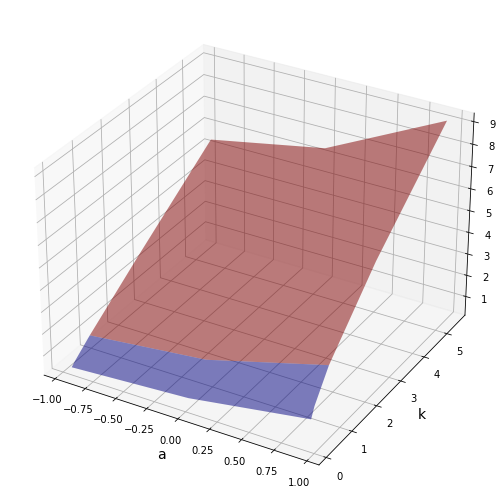

In [370]:
# Generate meshgrid coordinates for 3d plot
xg, yg = np.meshgrid(a_grid, k_grid)

# Plot approximation error
fig = plt.figure(figsize=(12,9))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(xg,
                yg,
                k_interp.T,
                rstride=2, cstride=2,
                cmap=cm.jet,
                alpha=0.5,
                linewidth=0.25)
ax.set_xlabel('a', fontsize=14)
ax.set_ylabel('k', fontsize=14)
plt.show()
plt.close()

### Chebyshev collocation as a least squares problem (overdetermined system)

In [35]:
n_k = 4 # degree of polynomials in k (number of coefficients is n_k + 1)
n_a = 2 # degree of polynomials in a (number of coefficients is n_a + 1)

nn_k = 30 # number of nodes for k
nn_a = 30 # number of nodes for a

n_quad = 12 # number of nodes and weights for quadrature (should be equal to total number of coefficients)

In [36]:
# Use the hermgauss function to get the nodes and weights for the Gauss-Hermite quadrature
gh_nodes, gh_weights = np.polynomial.hermite.hermgauss(n_quad)

gh_nodes = gh_nodes * np.sqrt(2) * σ_ε # convert z to ε

Since Chebyshev polynomials operate on the interval $[-1,1]$, we need to write a helper function that scales up state variables:

In [37]:
# generate chebyshev nodes (the roots of the chebyshev polynomials)
r_a = -np.cos((2*np.arange(1,nn_a+1) - 1) * np.pi / (2*nn_a))

# transform nodes into a space taking into account GH nodes
a_min = gh_nodes[0] + μ
a_max = gh_nodes[-1] + μ
a_grid = scale_up(r_a,a_min,a_max)

# builds the Vandermonde matrix of Chebyshev polynomial expansion at the r_a nodes
# using the recurrence relation
T_a = np.zeros((nn_a,n_a+1))

T_a[:,0] = np.ones((nn_a,1)).T

T_a[:,1] = r_a.T

for i in range(1,n_a):
    T_a[:,i+1] = 2 * r_a * T_a[:,i] - T_a[:,i-1]

# or numpy's routine
#T_a = np.polynomial.chebyshev.chebvander(r_a,n_a) 

In [38]:
# generate chebyshev nodes (the roots of the chebyshev polynomials)
r_k = -np.cos((2*np.arange(1,nn_k+1) - 1) * np.pi / (2*nn_k))

# transform nodes into k space
k_min = np.log(0.1)
k_max = np.log(6)
k_grid = np.exp(scale_up(r_k,k_min,k_max))

# builds the Vandermonde matrix of Chebyshev polynomial expansion at the r_a nodes
# using the recurrence relation
T_k = np.zeros((nn_k,n_k+1))

T_k[:,0] = np.ones((nn_k,1)).T

T_k[:,1] = r_k.T

for i in range(1,n_k):
    T_k[:,i+1] = 2 * r_k * T_k[:,i] - T_k[:,i-1]

# or numpy's routine
#T_k = np.polynomial.chebyshev.chebvander(r_k,n_k) 

In [39]:
# initial guess for policy function

c_init = np.zeros((nn_a,nn_k))

for i_a in range(nn_a):
    
    for i_k in range(nn_k):
        
        c_init[i_a,i_k] = np.exp(a_grid[i_a]) * k_grid[i_k]**α + (1 - δ) * k_grid[i_k]

# initial guess for Chebyshev coefficients
θ_init = (T_a.T @ np.log(c_init) @ T_k) / np.outer(np.diag(T_a.T @ T_a), np.diag(T_k.T @ T_k).T ) # use Matrix outer product for the denominator

In [40]:
θ_init

array([[ 6.62070021e-01,  1.24921572e+00,  1.04549118e-01,
         2.12165476e-03, -1.33619154e-03],
       [ 6.10010141e-01, -3.29025547e-01, -1.17448680e-02,
         1.01061666e-02,  6.90903136e-04],
       [ 5.83191588e-02,  8.50094940e-03, -1.17667955e-02,
        -1.15602231e-03,  7.29325124e-04]])

In [41]:
#@jit(nopython=False)
def residuals_ls(θ):
    """
    returns the residuals of the Euler equation using a Chebyshev approximation of the consumption policy function with coefficients θ.
    """
    
    θ = θ.reshape((n_a+1,n_k+1))
    
    ssr = np.zeros((nn_a,nn_k))

    for j_a in range(nn_a):

        for j_k in range(nn_k):

            c = np.exp(T_a[j_a,:] @ θ @ T_k[j_k,:].T)

            k_p = np.exp(a_grid[j_a]) * k_grid[j_k]**α - c + (1 - δ) * k_grid[j_k]
            
            k_p = np.fmin(np.fmax(k_p,np.exp(k_min)), np.exp(k_max))

            r_kp = scale_down(np.log(k_p),k_min,k_max)
            
            if np.any(np.abs(r_kp) > 1):
                print('Root of k outside unit circle at state point: ',j_a,j_k)

            T_kp = np.zeros((1,n_k+1))

            T_kp[:,0] = np.ones((1,1)).T

            T_kp[:,1] = r_kp #r_kp.T

            for i in range(1,n_k):
                T_kp[:,i+1] = 2 * r_kp * T_kp[:,i] - T_kp[:,i-1]

            # build vector of next period shocks using GH nodes
            a_p = ρ * a_grid[i_a] + (1 - ρ) * μ + gh_nodes
            
            a_p = np.where(a_p > a_min, a_p, a_min)
            
            a_p = np.where(a_p < a_max, a_p, a_max)

            # scale down next period shocks to [-1,1]
            r_ap = scale_down(a_p,a_min,a_max)
            
            if np.any(np.abs(r_ap) > 1):
                print('Root of a outside unit circle at state point: ',j_a,j_k)

            # build Chebyshev polynomials for next period shocks
            T_ap = np.zeros((len(r_ap),n_a+1))

            T_ap[:,0] = np.ones((len(r_ap),1)).T

            T_ap[:,1] = r_ap.T

            for i in range(1,n_a):
                T_ap[:,i+1] = 2 * r_ap.T * T_ap[:,i] - T_ap[:,i-1]

            # build vector for next period consumption
                        
            c_p = np.exp(T_ap @ θ @ T_kp.T)
             
            # compute expectations integral
            a_p = a_p.reshape((len(a_p),1))

            integrand = β * c_p**(-σ) * (α * np.exp(a_p) * k_p**(α - 1) + 1 - δ)

            E = gh_weights @ integrand / np.sqrt(np.pi) 

            ssr[j_a,j_k] = (np.log(E) - np.log(c**(-σ)))**2
                
    return np.nansum(ssr)

In [42]:
residuals_ls(θ_init)

5912.076515612964

In [43]:
# Find solution by minimizing the errors on the grid
hess = opt.BFGS(exception_strategy='skip_update', min_curvature=None, init_scale='auto')

θ_opt = opt.minimize(residuals_ls,θ_init.flatten(),method='trust-constr',jac='2-point',hess=hess).x
θ_opt = θ_opt.reshape((n_a+1,n_k+1))
print(θ_opt)

KeyboardInterrupt: 

In [425]:
def print_fun(x, f, accepted):
    
    """
    prints the value of every minimum found
    """
    
    print("at minimum %.4f accepted %d" % (f, int(accepted)))


minimizer_kwargs = {"method":"BFGS"}

ret = opt.basinhopping(residuals_ls, θ_opt, minimizer_kwargs=minimizer_kwargs,niter=10, callback=print_fun)

/home/maitlahcen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:67: RuntimeWarning: overflow encountered in matmul
/home/maitlahcen/anaconda3/lib/python3.7/site-packages/scipy/optimize/_numdiff.py:497: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


at minimum inf accepted 1


/home/maitlahcen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:65: RuntimeWarning: overflow encountered in multiply
/home/maitlahcen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:65: RuntimeWarning: overflow encountered in power
/home/maitlahcen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:69: RuntimeWarning: overflow encountered in double_scalars


at minimum inf accepted 1


/home/maitlahcen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:69: RuntimeWarning: invalid value encountered in subtract


at minimum nan accepted 1
at minimum nan accepted 1
at minimum nan accepted 1
at minimum nan accepted 1
at minimum nan accepted 1
at minimum nan accepted 1
at minimum nan accepted 1
at minimum nan accepted 1


In [396]:
residuals_ls(θ_opt)

47.52282028439606

In [264]:
# Find solution by minimizing the errors on the grid
θ_opt = opt.minimize(residuals_ls,θ_init.flatten(),method='SLSQP',options={'disp':True,'maxiter':100000,'xtol': 1e-10,'ftol': 1e-10}).x
θ_opt = θ_opt.reshape((n_a+1,n_k+1))
print(θ_opt)

/home/maitlahcen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: OptimizeWarning: Unknown solver options: xtol
  
/home/maitlahcen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/home/maitlahcen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:60: RuntimeWarning: overflow encountered in exp
/home/maitlahcen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:69: RuntimeWarning: divide by zero encountered in log
/home/maitlahcen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:69: RuntimeWarning: invalid value encountered in subtract
/home/maitlahcen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:65: RuntimeWarning: divide by zero encountered in power
/home/maitlahcen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:69: RuntimeWarning: divide by zero encountered in double_scalars
/home/maitlahcen/anaconda3/lib/python3.

KeyboardInterrupt: 

In [397]:
# Build approximation of f(x,y)
c_interp = np.exp(T_a @ θ_opt @ T_k.T)

In [398]:
# build next capital policy
k_interp = np.zeros((nn_a,nn_k))

for i_a in range(nn_a):
    
    for i_k in range(nn_k):
        
        k_interp[i_a,i_k] = np.exp(a_grid[i_a]) * k_grid[i_k]**α + (1 - δ) * k_grid[i_k] - c_interp[i_a,i_k]

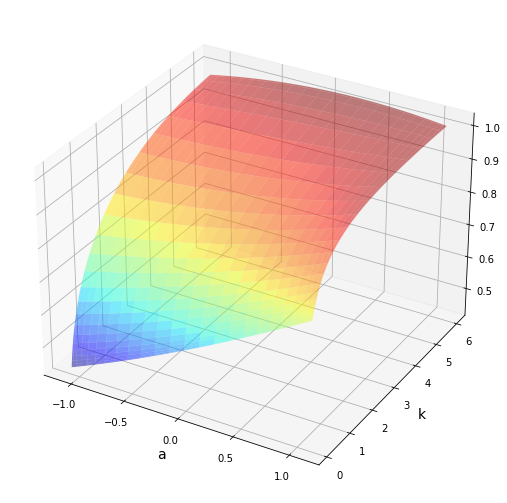

In [417]:
# Generate meshgrid coordinates for 3d plot
xg, yg = np.meshgrid(a_grid, k_grid)

# Plot approximation error
fig = plt.figure(figsize=(12,9))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(xg,
                yg,
                c_interp.T,
                rstride=2, cstride=2,
                cmap=cm.jet,
                alpha=0.5,
                linewidth=0.25)
ax.set_xlabel('a', fontsize=14)
ax.set_ylabel('k', fontsize=14)
plt.show()
plt.close()

In [411]:
#@jit(nopython=False)
def euler_residuals(θ):
    """
    returns the residuals of the Euler equation using a Chebyshev approximation of the consumption policy function with coefficients θ.
    """
    
    θ = θ.reshape((n_a+1,n_k+1))
    
    ssr = np.zeros((nn_a,nn_k))

    for j_a in range(nn_a):

        for j_k in range(nn_k):

            c = np.exp(T_a[j_a,:] @ θ @ T_k[j_k,:].T)

            k_p = np.exp(a_grid[j_a]) * k_grid[j_k]**α - c + (1 - δ) * k_grid[j_k]
            
            r_kp = scale_down(np.log(k_p),k_min,k_max)
            
            T_kp = np.zeros((1,n_k+1))

            T_kp[:,0] = np.ones((1,1)).T

            T_kp[:,1] = r_kp #r_kp.T

            for i in range(1,n_k):
                T_kp[:,i+1] = 2 * r_kp * T_kp[:,i] - T_kp[:,i-1]

            # build vector of next period shocks using GH nodes
            a_p = ρ * a_grid[i_a] + (1 - ρ) * μ + gh_nodes
            
            # scale down next period shocks to [-1,1]
            r_ap = scale_down(a_p,a_min,a_max)
                        
            # build Chebyshev polynomials for next period shocks
            T_ap = np.zeros((len(r_ap),n_a+1))

            T_ap[:,0] = np.ones((len(r_ap),1)).T

            T_ap[:,1] = r_ap.T

            for i in range(1,n_a):
                T_ap[:,i+1] = 2 * r_ap.T * T_ap[:,i] - T_ap[:,i-1]

            # build vector for next period consumption
                        
            c_p = np.exp(T_ap @ θ @ T_kp.T)
 
            # compute expectations integral
            a_p = a_p.reshape((len(a_p),1))

            integrand = β * c_p**(-σ) * (α * np.exp(a_p) * k_p**(α - 1) + 1 - δ)

            E = gh_weights @ integrand / np.sqrt(np.pi) 

            ssr[j_a,j_k] = (np.log(E) - np.log(c**(-σ)))
                
    return ssr

In [412]:
euler_resid_root = euler_residuals(θ_opt)

/home/maitlahcen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:53: RuntimeWarning: overflow encountered in multiply
/home/maitlahcen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:55: RuntimeWarning: overflow encountered in matmul


In [415]:
np.max(euler_resid_root)

inf

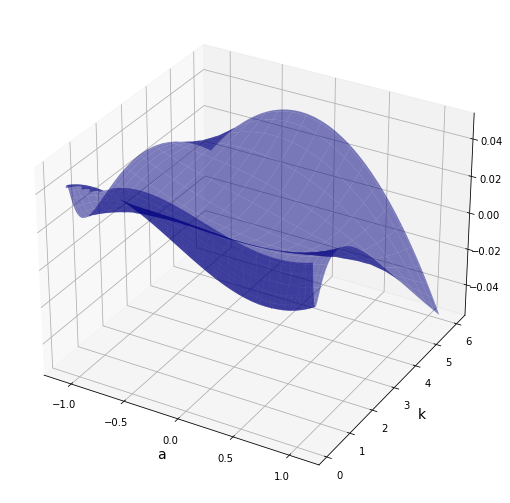

In [416]:
# Generate meshgrid coordinates for 3d plot
xg, yg = np.meshgrid(a_grid, k_grid)

# Plot approximation error
fig = plt.figure(figsize=(12,9))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(xg,
                yg,
                euler_resid_root.T,
                rstride=2, cstride=2,
                cmap=cm.jet,
                alpha=0.5,
                linewidth=0.25)
ax.set_xlabel('a', fontsize=14)
ax.set_ylabel('k', fontsize=14)
plt.show()
plt.close()